This notebook performs response-weighted analysis on the activation outputs of a traditional MNIST model.

# Initialisations

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import KernelDensity
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2

In [2]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(10*10*64, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x1 = self.conv1(x)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output, x1, x2

In [3]:
net = Net()
net.eval()
modelfilename = './MnistData/mnist_cnn.pt'
net.load_state_dict(torch.load(modelfilename)) # load the model
print(net)
print(net.state_dict().keys())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


# Weights Visualisation

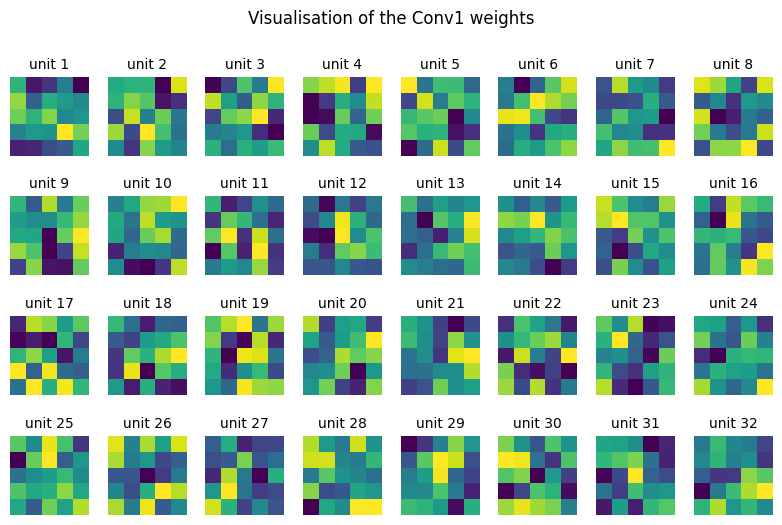

In [14]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)
plt.suptitle('Visualisation of the Conv1 weights')
plt.tight_layout()
plt.gcf().set_size_inches(8, 5.5)
plt.show()